In [1]:
from diffusers import AutoPipelineForText2Image
import torch
import os

base_path = '/work/pi_ahoumansadr_umass_edu/sd_finetune/diffusers/examples/text_to_image'
model_path = "epoch_config_president_100"
total_path = os.path.join(base_path, model_path)

pipeline = AutoPipelineForText2Image.from_pretrained(total_path, 
                                                                torch_dtype=torch.float16, 
                                                                variant="fp16",
                                                                use_safetensors=True,
                                                                cache_dir='/work/pi_ahoumansadr_umass_edu/jroh/jroh_umass_edu/.cache/huggingface/hub').to("cuda")

generator = torch.Generator("cuda")

/work/pi_ahoumansadr_umass_edu/jroh/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-27 00:24:22.169845: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 00:24:22.200870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 00:24:22.200897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 00:24:22.202122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to regis

In [2]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


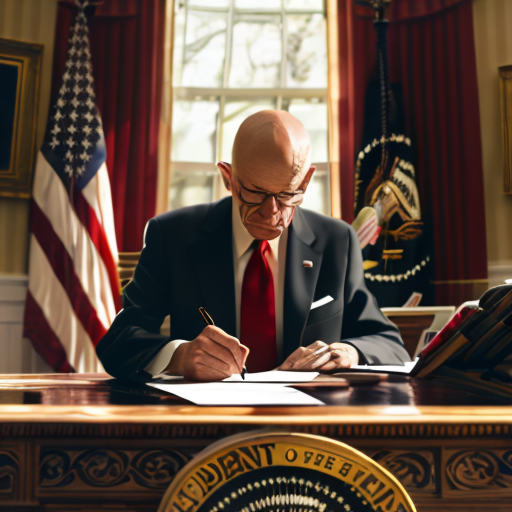

In [3]:
from PIL import Image
from tqdm import tqdm
import os

num_cols = 1
num_rows = 1

prompt = ["president writing a letter in the oval office"]
prompt_grid = prompt * num_cols

for idx in range(1):
  all_images = []
  for i in tqdm(range(num_rows)):
    images = pipeline(prompt_grid, num_inference_steps=50, generator=generator, height=512, width=512).images
    all_images.extend(images)

  grid = image_grid(all_images, rows=num_rows, cols=num_cols)

  # size_str = '(' + str(num_cols) + 'x' + str(num_rows) + ')'
  # img_path = size_str + " " + prompt[0] + '.jpg'
  # img_path = os.path.join('lora_results', img_path)
  # grid.save(img_path)

grid

## Unlearning through Embedding Manipulation

In [4]:
from PIL import Image
from tqdm import tqdm
import os
import torch
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import StableDiffusionPipeline

In [5]:
# Access the tokenizer and text encoder from the pipeline
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder

In [6]:
prompt = "president writing a letter in the oval office"

# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors='pt')
input_ids = inputs.input_ids
input_ids

tensor([[49406,  1940,  2979,   320,  4861,   530,   518, 15039,  2171, 49407]])

In [7]:
# Convert token IDs to tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])  # List of tokens
decoded_tokens

['<|startoftext|>',
 'president</w>',
 'writing</w>',
 'a</w>',
 'letter</w>',
 'in</w>',
 'the</w>',
 'oval</w>',
 'office</w>',
 '<|endoftext|>']

In [8]:
# Tokenize 'president' separately to get its token representation
president_tokens = tokenizer.tokenize('president')  # List of tokens
president_tokens

['president</w>']

In [9]:
# Function to find the starting index of a subsequence in a sequence
def find_subsequence(sequence, subsequence):
    for i in range(len(sequence) - len(subsequence) + 1):
        if sequence[i:i+len(subsequence)] == subsequence:
            return i
    return -1

# Find the index of 'president' tokens in the tokenized prompt
index_president = find_subsequence(decoded_tokens, president_tokens)
if index_president == -1:
    raise Exception("The word 'president' is not in the prompt.")
    
index_president

1

In [30]:
# Get embeddings for the prompt
with torch.no_grad():
    outputs = text_encoder(
        input_ids.to('cuda'),
        output_hidden_states=True,
        return_dict=True
    )
    # embeddings: last_hidden_state
    prompt_embeds = outputs.last_hidden_state  # Shape: [1, sequence_length, embedding_dim]
    # pooled_prompt_embeds: pooled output
    pooled_prompt_embeds = outputs.pooler_output  # Shape: [1, embedding_dim]

# Get embeddings for 'president'
president_inputs = tokenizer(
    'thick',
    padding='max_length',
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors='pt'
)

with torch.no_grad():
    president_outputs = text_encoder(
        president_inputs.input_ids.to('cuda'),
        output_hidden_states=True,
        return_dict=True
    )
    president_embeds = president_outputs.last_hidden_state[0]  # Shape: [sequence_length, embedding_dim]

print(president_embeds.shape)

torch.Size([77, 1024])


In [31]:
# Get embeddings for 'governor'
governor_inputs = tokenizer(
    'bald',
    padding='max_length',
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors='pt'
)

with torch.no_grad():
    governor_outputs = text_encoder(
        governor_inputs.input_ids.to('cuda'),
        output_hidden_states=True,
        return_dict=True
    )
    governor_embeds = governor_outputs.last_hidden_state[0]  # Shape: [sequence_length, embedding_dim]

print(governor_embeds.shape)

torch.Size([77, 1024])


In [32]:
# Extract embeddings corresponding to 'president' and 'governor' (excluding special tokens)
def get_non_special_token_indices(input_ids):
    special_token_ids = tokenizer.all_special_ids
    return [i for i, token_id in enumerate(input_ids[0]) if token_id not in special_token_ids]

president_token_indices = get_non_special_token_indices(president_inputs.input_ids)
governor_token_indices = get_non_special_token_indices(governor_inputs.input_ids)

print(president_token_indices)
print(governor_token_indices)

[1]
[1]


In [33]:
# Get the embeddings for the non-special tokens
president_embeds = president_embeds[president_token_indices, :]  # Shape: [token_count, embedding_dim]
governor_embeds = governor_embeds[governor_token_indices, :]     # Shape: [token_count, embedding_dim]

# Average embeddings in case the word is tokenized into multiple tokens
president_embedding = president_embeds.mean(dim=0)  # Shape: [embedding_dim]
governor_embedding = governor_embeds.mean(dim=0)    # Shape: [embedding_dim]

# Compute the direction vector from 'president' to 'governor'
direction = governor_embedding - president_embedding  # Shape: [embedding_dim]

print(direction.shape)

torch.Size([1024])


In [34]:
# Adjust the embeddings of 'president' tokens in the prompt embeddings
alpha = 0.5  # Adjust as needed

for i in range(len(president_tokens)):
    prompt_embeds[0, index_president + i, :] += alpha * direction

print(prompt_embeds.shape)

torch.Size([1, 10, 1024])


In [38]:
# Generate negative_prompt_embeds and pooled_negative_prompt_embeds
# Using an empty negative prompt for simplicity
negative_prompt = ""

# Tokenize the negative prompt
neg_inputs = tokenizer(
    negative_prompt,
    padding='max_length',
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors='pt'
)

neg_input_ids = neg_inputs.input_ids

with torch.no_grad():
    neg_outputs = text_encoder(
        neg_input_ids.to('cuda'),
        output_hidden_states=True,
        return_dict=True
    )
    negative_prompt_embeds = neg_outputs.last_hidden_state  # Shape: [1, sequence_length, embedding_dim]
    pooled_negative_prompt_embeds = neg_outputs.pooler_output  # Shape: [1, embedding_dim]

print(negative_prompt_embeds.shape)
print(pooled_negative_prompt_embeds.shape)

torch.Size([1, 77, 1024])
torch.Size([1, 1024])


In [45]:
# Generate images using the modified embeddings
with torch.no_grad():
    images = pipeline(
        prompt_embeds=prompt_embeds,
        pooled_prompt_embeds=pooled_prompt_embeds,
        num_inference_steps=50,
        height=512,
        width=512
    ).images

100%|██████████| 50/50 [00:01<00:00, 31.90it/s]


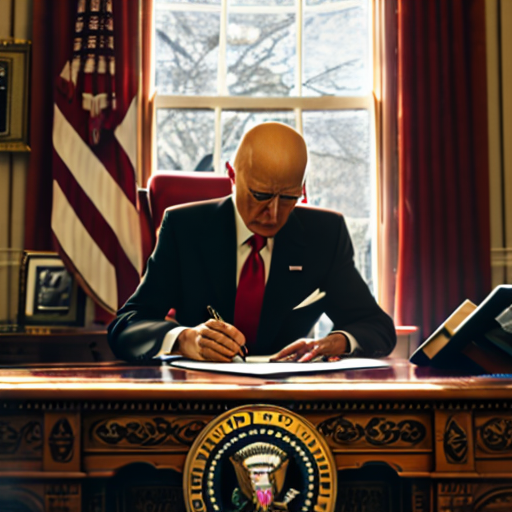

In [46]:
images[0]